# Study of debtors' reliability

In [1]:
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
try:
    data = pd.read_csv('/Users/anshilina/Documents/data.csv')
except:
    data = pd.read_csv('datasets/data.csv')

In [3]:
data.head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


There are missing values in two columns: `days_employed` and `total_income`. Regarding `total_income` variable, income depends on the type of employment, so let's fill in the NAs using the median value for each type of employment (`income_type` column). For example, for a person with `employee` type, missing income values should be filled by the median income value among all `employees`. 

In [5]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [6]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()

### Data outliers preprocessing

Negative values in the `days_employed` column (seniority in days) are outliers. Let's replace them with positive ones using the `abs()` method.

In [7]:
data['days_employed'] = data['days_employed'].abs()

Then for each type of employment, let's display the median value of `days_employed`.

In [8]:
data.groupby('income_type')['days_employed'].agg('median')

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

There are unusually large values for pensioners and unemployed people. At this stage, the nature of outliers is unknown, therefore, it is difficult to correct these values. We will not need this column for data analysis so we can ignore it for now.

Now let's display the unique values from the `children` column (number of children).

In [9]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

There are unusual negative values. Let's remove these rows from the dataframe.

In [10]:
data = data[(data['children'] != -1) & (data['children'] != 20)]
data['children'].unique()

array([1, 0, 3, 2, 4, 5])

### Missing values preprocessing

Let's fill the missing values in `days_employed` column with the median value for each `income_type`.

In [11]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

In [12]:
data.isna().sum().sum()

0

There are three [types](https://loginom.ru/blog/missing) of the missing values: *missing completely at random*; *missing at random* (are not completely random and occure due to some patterns that can be identified based on the available data); and *missing not at random* (are absent for unknown reasons and these reasons cannot be determined based on the available data). 

The reasons for missing values in the `days_employed` and `total_income` columns cannot be determined using the available data. We found out that those who did not report their total work experience also did not report their monthly income. Thus, it cannot be argued that variables were omitted *completely at random*. In addition, it is also impossible to explain missing values based on the data. Therefore, values are missing **not at random**. We don't have enough data to explain the nature of these missings. It could be either a technical error or a human factor (for example, a bank employee did not specify the total work experience and monthly income of these clients).

### Changing data types

Let's replace float value type in the `total_income` column with integer one using `astype()` method.

In [13]:
data['total_income'] = data['total_income'].astype(int)

### Duplicates preprocessing

Let's preprocess implicit duplicates in the `education` column. This column has the same values written differently – using uppercase and lowercase letters. Let's convert all of them to the lower case.

In [14]:
data['education'] = data['education'].str.lower()

Now let's display the number of duplicated rows and delete them.

In [15]:
data.duplicated().sum()

71

In [16]:
data = data.drop_duplicates()

### Data categorization

Using the ranges below, let's add `total_income_category` column to the dataframe:

- 0–30000 — `'E'`
- 30001–50000 — `'D'`
- 50001–200000 — `'C'`
- 200001–1000000 — `'B'`
- 1000001 and above — `'A'`

In [17]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

In [18]:
data['total_income_category'] = data['total_income'].apply(categorize_income)

Then let's display a list of unique values from the `purpose` column (for what purposes people usually take a loan).

In [19]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Let's categorize data based on the values of the `purpose` column:

- `'операции с автомобилем'` (auto), 
- `'операции с недвижимостью'` (realty),
- `'проведение свадьбы'` (wedding),
- `'получение образования'` (education).

In [20]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'auto'
        elif 'жил' in row or 'недвиж' in row:
            return 'realty'
        elif 'свад' in row:
            return 'wedding'
        elif 'образов' in row:
            return 'education'
    except:
        return 'нет категории'

In [21]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

### Data analysis

To study the relationship between *number of children* and *debt repaymnet* let's group data by `children` variable and calculate the proportion of debtors in each group (`debt` variable). Since the `debt` variable is binary, we can use the group average to calculate proportion.

In [22]:
for children_num, debt in data.groupby('children')['debt']:
    print(f'Number of children: {children_num}.') 
    print(f'People in group: {debt.count()}, proportion of debtors: {debt.mean()}')
    print('**************')

Number of children: 0.
People in group: 14091, proportion of debtors: 0.07543822297920659
**************
Number of children: 1.
People in group: 4808, proportion of debtors: 0.09234608985024959
**************
Number of children: 2.
People in group: 2052, proportion of debtors: 0.09454191033138401
**************
Number of children: 3.
People in group: 330, proportion of debtors: 0.08181818181818182
**************
Number of children: 4.
People in group: 41, proportion of debtors: 0.0975609756097561
**************
Number of children: 5.
People in group: 9, proportion of debtors: 0.0
**************


Let's visualize data.

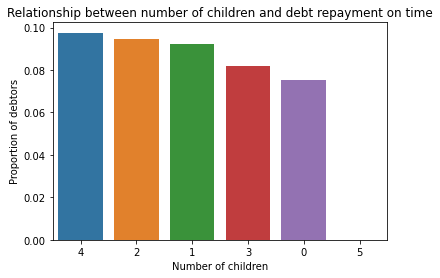

In [23]:
grouped_data = data.groupby('children')['debt'].mean()
grouped_data = grouped_data.sort_values(ascending=False).reset_index()
grouped_data['children'] = grouped_data['children'].astype('str')

seaborn.barplot(x=grouped_data['children'], y=grouped_data['debt'])
plt.xlabel('Number of children')
plt.ylabel('Proportion of debtors')
plt.title('Relationship between number of children and debt repayment on time')
plt.show()

There is no linear relationship between the number of children in family and the on time repayment of debt.

Besides, we noted that the sample includes only 9 families with 5 children. To double-check the results, we can categorize variable and see how **large families** and **not large families** cope with loan obligations. In Russia, a family with three or more minor children is considered to be a large family. Using this approach, we will divide the sample based on the values of the `children` variable.

In [24]:
def large_family(series):
    if series >= 3:
        return 'large families'
    else:
        return 'not large families'
    
data['children_status'] = data['children'].apply(large_family)

Let's calculate the proportion of debtors in the group of large and not large families.

In [25]:
for status, debt in data.groupby('children_status')['debt']:
    print(f'Family status: {status}. People in group: {debt.count()}, proportion of debtors: {debt.mean()}')

Family status: large families. People in group: 380, proportion of debtors: 0.08157894736842106
Family status: not large families. People in group: 20951, proportion of debtors: 0.08118944203140661


It can be seen that the results for two groups are the same (the difference is **0.04%**). Let's visualize the data.

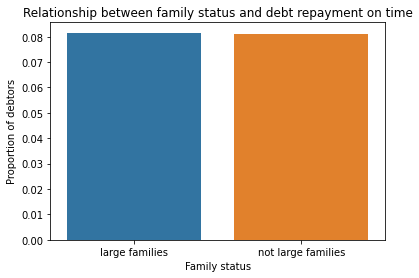

In [26]:
grouped_data = data.groupby('children_status')['debt'].mean()
grouped_data = grouped_data.sort_values(ascending=False).reset_index()

seaborn.barplot(x=grouped_data['children_status'], y=grouped_data['debt'])

plt.xlabel('Family status')
plt.ylabel('Proportion of debtors')
plt.title('Relationship between family status and debt repayment on time')
plt.show()

**Summary:** There is no relationship between the number of children in family and the repayment of debt on time. The proportion of the debtors among people with 1-2 and 4 children are approximately equal (**9.2-9.8%**). There are fewer debtors among people with 3 children (**8%**) and people with no children (**7.5%**). Among those who have 5 children, the proportion of debtors in this sample is **0%**. We grouped data by the number of children and studied **large families** and **not large families**. As the result, we found out that there is no relationship between the number of children in family and the ability to repay debt on time.

To study the relationship between *marital status* and *debt repayment*, let's group data by marital status and estimate the proportion of debtors in each group. To group data, we will use `family_status` variable and to determine the proportion of debtors we will estimate groups average of the `debt` variable.

In [27]:
# Ваш код будет здесь. Вы можете создавать новые ячейки.
data['family_status'] = data['family_status'].str.lower() # приведем все название категорий к одному регистру

for marital_status, debt in data.groupby('family_status')['debt']:
    print(f'Marital status: {marital_status}.')
    print(f'People in group: {debt.count()}, proportion of debtors: {debt.mean()}')
    print('**************')

Marital status: в разводе.
People in group: 1189, proportion of debtors: 0.07064760302775441
**************
Marital status: вдовец / вдова.
People in group: 951, proportion of debtors: 0.06624605678233439
**************
Marital status: гражданский брак.
People in group: 4134, proportion of debtors: 0.09313014029995162
**************
Marital status: женат / замужем.
People in group: 12261, proportion of debtors: 0.07560557866405676
**************
Marital status: не женат / не замужем.
People in group: 2796, proportion of debtors: 0.09763948497854077
**************


Let's visualize the data.

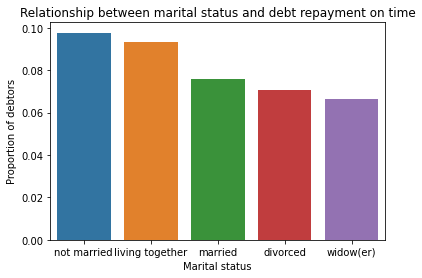

In [28]:
grouped_data = data.groupby('family_status')['debt'].mean()
grouped_data = grouped_data.sort_values(ascending=False).reset_index()

seaborn.barplot(x=grouped_data['family_status'], y=grouped_data['debt'])

bars = ('not married', 'living together', 'married', 'divorced', 'widow(er)')
x_pos = np.arange(len(bars))

plt.xticks(x_pos, bars)
plt.xlabel('Marital status')
plt.ylabel('Proportion of debtors')
plt.title('Relationship between marital status and debt repayment on time')
plt.show()

**Summary:** There are a lot of debtors among those who have never been married (**9,76%**). Widowers are better at repaying debts (~6,6%) than those who are married, divoreced or who are just living together without marriage – the proportion of debtors is **7,6%**, **7%**, and **9,3%** respectively.

To check the relationship between *income level* and *debt repayment*, we will group observations according to income categories and calculate the proportion of debtors in each groups. There are five categories of income (variable `total_income_category`):

- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.

Let's calculate the proportion of debtors in each group.

In [29]:
# Ваш код будет здесь. Вы можете создавать новые ячейки.
for income_cat, debt in data.groupby('total_income_category')['debt']:
    print(f'Income category: {income_cat}')
    print(f'People in group: {debt.count()}, proportion of debtors: {debt.mean()}')
    print('**************')

Income category: A
People in group: 25, proportion of debtors: 0.08
**************
Income category: B
People in group: 5014, proportion of debtors: 0.07060231352213801
**************
Income category: C
People in group: 15921, proportion of debtors: 0.08498209911437724
**************
Income category: D
People in group: 349, proportion of debtors: 0.06017191977077364
**************
Income category: E
People in group: 22, proportion of debtors: 0.09090909090909091
**************


Then, we visualize the data.

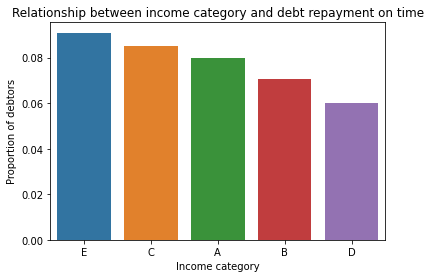

In [30]:
grouped_data = data.groupby('total_income_category')['debt'].mean()
grouped_data = grouped_data.sort_values(ascending=False).reset_index()

seaborn.barplot(x=grouped_data['total_income_category'], y=grouped_data['debt'])

plt.xlabel('Income category')
plt.ylabel('Proportion of debtors')
plt.title('Relationship between income category and debt repayment on time')
plt.show()

**Summary:** The majority of debtors (**9%**) are those who's income does not exceed 30,000 rubles (category E). People with an income of more than 50,000 rubles (A, B or C category) are worse than the "middle class" (category D) in repaying debts. People with an average income (30-50,000 rubles), who were assigned to category D, better than others repay the debts (the proportion of debtors among them is **6%**).

To study the relationship between *purpose of loan* and *debt repayment on time*, let's group data depending on the loan purpose. Then we will calculate the proportion of debtors in each group. Therefore, we will determine which loans are usually repaid on time. To group the data, we will use the `purpose_category` variable, which indicates the purpose for which the loan was issued:

- `'auto'`,
- `'realty'`,
- `'wedding'`,
- `'education'`.

In [31]:
# Ваш код будет здесь. Вы можете создавать новые ячейки.
for purpose, debt in data.groupby('purpose_category')['debt']:
    print(f'Loan purpose: {purpose}')
    print(f'People in group: {debt.count()}, proportion of debtors: {debt.mean()}')
    print('**************')

Loan purpose: auto
People in group: 4279, proportion of debtors: 0.09347978499649451
**************
Loan purpose: education
People in group: 3988, proportion of debtors: 0.09252758274824474
**************
Loan purpose: realty
People in group: 10751, proportion of debtors: 0.07255139056831923
**************
Loan purpose: wedding
People in group: 2313, proportion of debtors: 0.07911802853437094
**************


Let's visualize the data.

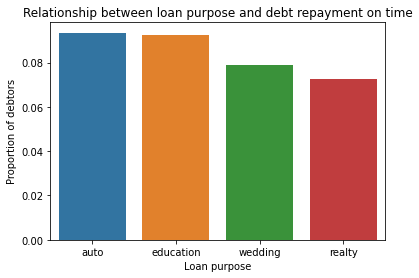

In [32]:
grouped_data = data.groupby('purpose_category')['debt'].mean()
grouped_data = grouped_data.sort_values(ascending=False).reset_index()

seaborn.barplot(x=grouped_data['purpose_category'], y=grouped_data['debt'])

plt.xlabel('Loan purpose')
plt.ylabel('Proportion of debtors')
plt.title('Relationship between loan purpose and debt repayment on time')
plt.show()

**Summary:** There are **7.26%** debtors among those who arranged a mortgage. The proportion of debtors is slightly higher (**7.9%**) among those who took out a loan for wedding. There are a lot of debtors among students or thier parents who took out a loan for education perposes (**9.25%**). Finally, the proportion of debtors is the highest (**9.3%**) among those who took out a loan for buying a car.

### Conclusion

**Data preprocessing:**
* At the first stage, missing values were identified in the `days_employed` and `total_income` variables. Since monthly income (`total_income`) dependends on the type of employment, the group median value was used to fill in NA values. Examining the variable `days_employed`, outliers were found (values for *retirees* and *unemployed*). Due to outliers, we used group median to fill NA in this variable.
* In addition, outliers were found in other variables. Negative values for the `days_employed` variable were replaced by the modulus of these values, and observations with negative values of the `children` variable were dropped.
* Then we changed `total_income` variable type from float to integer.
* We have also dropped implicit duplicates from the data.
* Finally, we categorized the `total_income` variable and created income categories A-E. Then we categorized the `purpose` variable, dividing the purpose of the loan into 1) realty transactions, 2) car transactions, 3) wedding, 4) education.

**Data analysis:**
* There is no linear relationship between the number of children and the debt repayment on time: large and non-large families similarly cope with loan obligations.
* There are less debtors among widowers and divorcees than among those who have never been married. We assume that it depends on another variable, for example, age.
* We assume that there is a quadratic (U-shaped) relationship between the income level and repayment of the loan on time: the most debtors are among those whose income does not exceed 30 thousand and among people with above-average incomes (from 50 thousand rubles). The middle class (income of 30-50 thousand rubles) copes with loan obligations better than others.
* There is a relationship between the purpose of the loan and debt repayments on time. Those who arranged a mortgage better than others cope with loan obligations. The proportion of debtors is higher among students and drivers.